In [1]:
# Installing the Backtrader Library
!pip install backtrader

     |████████████████████████████████| 419kB 11.1MB/s 


In [2]:
# Importing the required packages
from __future__ import (absolute_import, division, print_function, unicode_literals)

import warnings
warnings.filterwarnings('ignore')

import datetime # for datetime information
import os.path  # to manage paths
import sys      # to find out the script name (in argv[0])

import backtrader as bt # Importing the Backtrader library

**SMA (Simple Moving Average)**

In [3]:
# Coding the strategy

class SMA_strategy(bt.Strategy):
    params = (('maperiod', 15),)

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt)) 

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # Add a MovingAverageSimple indicator
        self.SMA_strategy = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.maperiod)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy(): # Buy
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending; if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] > self.SMA_strategy[0]:

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.buy()

        else:

            if self.dataclose[0] < self.SMA_strategy[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

Starting Portfolio Value: 10000.00
2018-01-23, Close, 42.59
2018-01-23, BUY CREATE, 42.59
2018-01-24, BUY EXECUTED, Price: 42.64, Cost: 4264.00, Comm 0.00
2018-01-24, Close, 41.91
2018-01-24, SELL CREATE, 41.91
2018-01-25, SELL EXECUTED, Price: 41.98, Cost: 4264.00, Comm 0.00
2018-01-25, OPERATION PROFIT, GROSS -66.00, NET -66.00
2018-01-25, Close, 41.17
2018-01-26, Close, 41.26
2018-01-29, Close, 40.41
2018-01-30, Close, 40.17
2018-01-31, Close, 40.28
2018-02-01, Close, 40.36
2018-02-02, Close, 38.61
2018-02-05, Close, 37.65
2018-02-06, Close, 39.22
2018-02-07, Close, 38.38
2018-02-08, Close, 37.33
2018-02-09, Close, 37.78
2018-02-12, Close, 39.30
2018-02-13, Close, 39.70
2018-02-13, BUY CREATE, 39.70
2018-02-14, BUY EXECUTED, Price: 39.38, Cost: 3938.00, Comm 0.00
2018-02-14, Close, 40.43
2018-02-15, Close, 41.79
2018-02-16, Close, 41.65
2018-02-20, Close, 41.51
2018-02-21, Close, 41.32
2018-02-22, Close, 41.67
2018-02-23, Close, 42.39
2018-02-26, Close, 43.23
2018-02-27, Close, 43.0

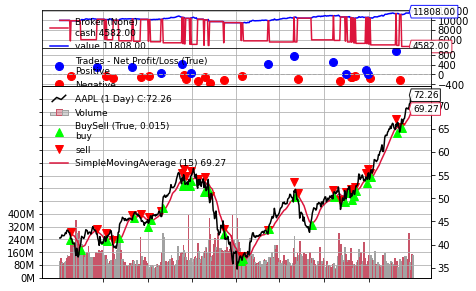

In [4]:
# SMA - Simple Moving Average Indicator

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(SMA_strategy)

        # Create a Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname='AAPL',
        fromdate=datetime.datetime(2018, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2019, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot(iplot=False)

**RSI (Relative Strength Index)**

In [12]:
# Coding the strategy

class RSI_strategy(bt.Strategy):
	params=(('minimum_RSI', 30),('maximum_RSI', 70),('look_back_period', 14))

	def log(self, txt, dt=None):
		dt = dt or self.datas[0].datetime.date(0)
		print('%s, %s' % (dt.isoformat(), txt))

	def __init__(self):
		# RSI indicator
		self.RSI_strategy = bt.indicators.RSI_SMA(self.data.close, period=self.params.look_back_period) 

	def notify_order(self, order):
		if order.status in [order.Submitted, order.Accepted]:
		# Buy/Sell order submitted/accepted to/by broker - Nothing to do
			return

		# Check if an order has been completed
		# Attention: Broker could reject order if not enough cash
		if order.status in [order.Completed]:
			if order.isbuy():
				self.log('BUY EXECUTED, %.2f' % order.executed.price)
			elif order.issell():
				self.log('SELL EXECUTED, %.2f' % order.executed.price) 

			self.bar_executed = len(self)

		elif order.status in [order.Canceled, order.Margin, order.Rejected]:
			self.log('Order Cancelled/Margin/Rejected')

		# Write down: no pending order
		self.order = None

	def next(self):

		# Buy if over sold
		if self.RSI_strategy < self.params.minimum_RSI:
			self.buy()

		# Sell if over buyed
		if self.RSI_strategy > self.params.maximum_RSI:
			self.close()

Starting Portfolio Value: 10000.00
2018-02-05, BUY EXECUTED, 38.28
2018-02-06, BUY EXECUTED, 37.25
2018-02-07, Order Cancelled/Margin/Rejected
2018-02-08, Order Cancelled/Margin/Rejected
2018-02-09, Order Cancelled/Margin/Rejected
2018-02-12, Order Cancelled/Margin/Rejected
2018-02-27, SELL EXECUTED, 43.26
2018-03-26, BUY EXECUTED, 40.60
2018-04-03, BUY EXECUTED, 40.50
2018-04-19, SELL EXECUTED, 41.97
2018-06-25, BUY EXECUTED, 44.47
2018-06-26, BUY EXECUTED, 44.37
2018-06-27, Order Cancelled/Margin/Rejected
2018-06-28, Order Cancelled/Margin/Rejected
2018-07-25, SELL EXECUTED, 46.82
2018-11-15, BUY EXECUTED, 46.00
2018-11-21, BUY EXECUTED, 43.89
2018-11-23, Order Cancelled/Margin/Rejected
2018-11-26, Order Cancelled/Margin/Rejected
2018-11-27, Order Cancelled/Margin/Rejected
2018-11-28, Order Cancelled/Margin/Rejected
2018-11-29, Order Cancelled/Margin/Rejected
2018-11-30, Order Cancelled/Margin/Rejected
2018-12-03, Order Cancelled/Margin/Rejected
2018-12-11, Order Cancelled/Margin/Rej

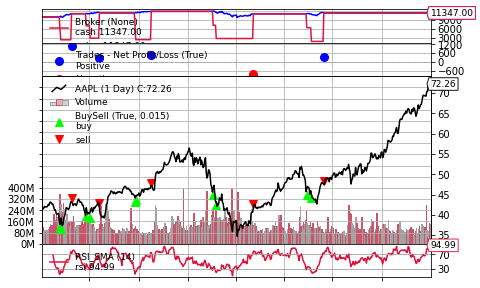

In [13]:
# RSI - Relative Strength Index Indicator

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(RSI_strategy)

        # Create a Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname='AAPL',
        fromdate=datetime.datetime(2018, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2019, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot(iplot = False)

**MACD (Moving Average Convergence Divergence)**

In [14]:
# Coding the strategy for MACD Indicator

class MACD_strategy(bt.Strategy):
  params=(('fast_LBP',14), ('slow_LBP',26), ('BBands_LBP',20))

  def log(self, txt, dt=None):
    dt = dt or self.datas[0].datetime.date(0)
    print('%s, %s' % (dt.isoformat(), txt)) 

  def __init__(self):
    self.dataclose = self.datas[0].close
    self.fast_EMA =  bt.indicators.ExponentialMovingAverage(self.data, period=self.params.fast_LBP)
    self.slow_EMA = bt.indicators.ExponentialMovingAverage(self.data, period=self.params.slow_LBP)

    self.MACD_strategy = self.fast_EMA-self.slow_EMA
    self.bband = bt.indicators.BBands(self.datas[0], period=self.params.BBands_LBP)
    self.order = None
    self.inc_ = None
    self.dec_ = None 

  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
      return
    if order.status in [order.Completed]:
      if order.isbuy():
        self.log('BUY EXECUTED, %.2f' % order.executed.price)
      elif order.issell():
        self.log('SELL EXECUTED, %.2f' % order.executed.price)

      self.bar_executed = len(self)
    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('Order Canceled/Margin/Rejected')

    self.order = None
    
  def next(self):
    if not self.order and not self.position:
      if self.MACD_strategy > 0:
        self.log('LONG -BUY, %.2f' % self.dataclose[0])
        self.inc_=True
        self.order = self.buy()
      elif self.MACD_strategy < 0:
        self.log('SHORT-SELL, %.2f' % self.dataclose[0])
        self.dec_=True
        self.order = self.sell()

    elif not self.order and  self.position :
      if self.MACD_strategy > 0 and self.dec_:
        self.log('BUY, %.2f' % self.dataclose[0])
        self.dec_=None
        self.order = self.buy()
      elif self.MACD_strategy < 0 and self.inc_:
        self.log('SELL, %.2f' % self.dataclose[0])
        self.inc_=None
        self.order = self.sell()
      if self.dataclose[0] > self.bband.lines.top and self.inc_ :
        self.log('SELL, %.2f' % self.dataclose[0])
        self.inc_=None
        self.order = self.sell()
      elif self.dataclose[0] < self.bband.lines.bot and  self.dec_:
        self.log('BUY, %.2f' % self.dataclose[0])
        self.dec_=None
        self.order = self.buy()

Starting Portfolio Value: 10000.00
2018-02-07, SHORT-SELL, 38.38
2018-02-08, SELL EXECUTED, 38.56
2018-02-27, BUY, 43.09
2018-02-28, BUY EXECUTED, 43.30
2018-02-28, LONG -BUY, 43.03
2018-03-01, BUY EXECUTED, 43.13
2018-03-23, SELL, 39.84
2018-03-26, SELL EXECUTED, 40.60
2018-03-26, SHORT-SELL, 41.73
2018-03-27, SELL EXECUTED, 41.95
2018-04-16, BUY, 42.47
2018-04-17, BUY EXECUTED, 42.63
2018-04-17, LONG -BUY, 43.06
2018-04-18, BUY EXECUTED, 42.95
2018-04-23, SELL, 39.92
2018-04-24, SELL EXECUTED, 40.02
2018-04-24, SHORT-SELL, 39.36
2018-04-25, SELL EXECUTED, 39.28
2018-05-04, BUY, 44.41
2018-05-07, BUY EXECUTED, 44.73
2018-05-07, LONG -BUY, 44.73
2018-05-08, BUY EXECUTED, 44.69
2018-06-04, SELL, 46.52
2018-06-05, SELL EXECUTED, 46.82
2018-06-05, LONG -BUY, 46.88
2018-06-06, BUY EXECUTED, 46.95
2018-06-06, SELL, 47.04
2018-06-07, SELL EXECUTED, 47.08
2018-06-07, LONG -BUY, 46.91
2018-06-08, BUY EXECUTED, 46.36
2018-06-27, SELL, 44.66
2018-06-28, SELL EXECUTED, 44.64
2018-06-28, SHORT-SEL

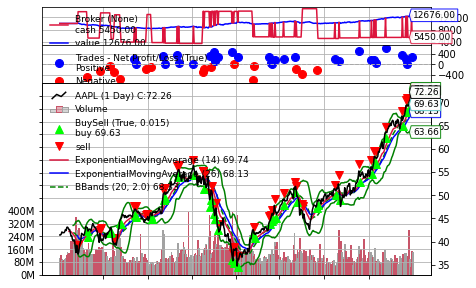

In [15]:
# Implementing Moving Average Convergence Divergence - MACD

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(MACD_strategy) 

        # Create a Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname='AAPL',
        fromdate=datetime.datetime(2018, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2019, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(10000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Plot the result
    cerebro.plot(iplot=False)

**BB (Bollinger Bands)**

In [16]:
# Coding the Bollinger Bands strategy

class BBandStrategy(bt.Strategy):
    params = (('period', 30),('d_factor', 3.0),)
    
    def log(self, text, dt = None):
        dt = dt or self.datas[0].datetime.date(0)
        print("%s %s" %(dt.isoformat(), text))
        
    def __init__(self):
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a Bollinger Bands indicator
        self.bband = bt.indicators.BollingerBands(self.datas[0], period=self.p.period, devfactor=self.p.d_factor)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
            self.bar_executed = len(self)
        elif order.status in [order.Rejected]:
            self.log('Order Rejected')
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
        elif order.status in [order.Margin]:
            self.log('Order Margin')
        # Reset
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %(trade.pnl, trade.pnlcomm))
    
    def next(self):
        # Check if an order is pending; if yes, then we cannot send a 2nd one
        if self.order:
            return
        # Check if we are in the market
        if not self.position:
            # if the close value is lower than Bollinger low: it is a buying opportunity
            if self.data.close < self.bband.lines.bot:
                # Let's go long (Buy)
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                # Keep track of the already created order to avoid a 2nd order
                self.order = self.buy()
            # if the close value is greater than Bollinger high: it is a selling opportunity 
            elif self.data.close > self.bband.lines.top:
                # SELL, SELL, SELL!!! (Since we are not in market let's Short)
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                # Keep track of the already created order to avoid a 2nd order
                self.order = self.sell()
        else:
            # exiting the long position; reaching the midline can be a good target
            if self.position.size>0 and self.data.close >= self.bband.lines.mid:
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                # Keep track of the created order to avoid a 2nd order
                self.order = self.close()
            # exiting the short position; reaching the midline can be a good target
            elif self.position.size<0 and self.data.close <= self.bband.lines.mid:
                #Buy
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                # Keep track of the already created order to avoid a 2nd order
                self.order = self.close()

2003-09-02 SELL CREATE, 11.91
2003-09-03 SELL EXECUTED, Price: 12.21, Cost: -122.10, Comm 1.22
2003-09-17 BUY CREATE, 10.92
2003-09-18 BUY EXECUTED, Price: 10.91, Cost: -122.10, Comm 1.09
2003-09-18 OPERATION PROFIT, GROSS 13.00, NET 10.69
2004-09-15 SELL CREATE, 10.08
2004-09-16 SELL EXECUTED, Price: 10.01, Cost: -100.10, Comm 1.00
2004-11-22 BUY CREATE, 11.28
2004-11-23 BUY EXECUTED, Price: 11.21, Cost: -100.10, Comm 1.12
2004-11-23 OPERATION PROFIT, GROSS -12.00, NET -14.12
2004-12-13 SELL CREATE, 13.01
2004-12-14 SELL EXECUTED, Price: 12.86, Cost: -128.60, Comm 1.29
2005-01-04 BUY CREATE, 11.62
2005-01-05 BUY EXECUTED, Price: 11.59, Cost: -128.60, Comm 1.16
2005-01-05 OPERATION PROFIT, GROSS 12.70, NET 10.25
2005-06-29 SELL CREATE, 12.07
2005-06-30 SELL EXECUTED, Price: 12.06, Cost: -120.60, Comm 1.21
2005-08-03 BUY CREATE, 11.90
2005-08-04 BUY EXECUTED, Price: 11.79, Cost: -120.60, Comm 1.18
2005-08-04 OPERATION PROFIT, GROSS 2.70, NET 0.32
2005-09-23 BUY CREATE, 11.07
2005-09-26 

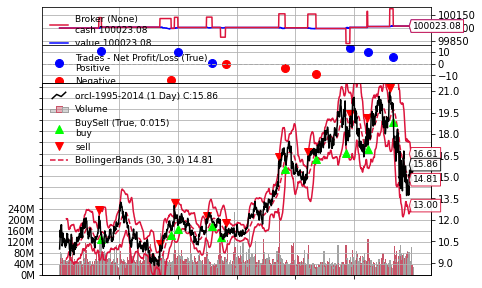

In [17]:
if __name__ == "__main__":
    cerebro = bt.Cerebro()
    data = bt.feeds.YahooFinanceCSVData(
        dataname = 'orcl-1995-2014.txt',
        # Do not pass values before this date
        fromdate=datetime.datetime(2003, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2008, 12, 31),
        reverse=False
    ) 
    
    # Add data
    cerebro.adddata(data)

    # Add strategy
    cerebro.addstrategy(BBandStrategy)

    # Fix the size
    cerebro.addsizer(bt.sizers.SizerFix, stake=10)

    # Initial investment
    cerebro.broker.setcash(100000.0)  

    # Some money for the broker
    cerebro.broker.setcommission(commission=0.01)

    start_portfolio_value = cerebro.broker.getvalue()

    cerebro.run()

    end_portfolio_value = cerebro.broker.getvalue()
    
    print("Starting portfolio value: %s \nEnding portfolio value: %s \nPnl: %s" \
          %(start_portfolio_value,end_portfolio_value,end_portfolio_value-start_portfolio_value))
    
    cerebro.plot(iplot=False)